In [7]:
# Step 1: Load Dataset
import pandas as pd

# Direct URL to CSV (mock database)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# Show first 5 rows
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


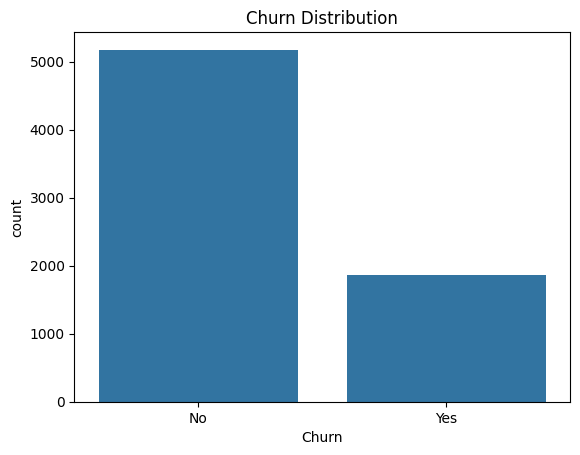

In [8]:
# Step 2: Quick Overview (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Column info and statistics
df.info()
df.describe()

# Churn distribution bar chart
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()


In [9]:
# Step 3: Total Customers & Churn Counts

# 1. Count total customers
total_customers = len(df)
print("Total customers:", total_customers)

# 2. Count churned vs active customers
churn_counts = df['Churn'].value_counts()
print("\nChurn counts:\n", churn_counts)


Total customers: 7043

Churn counts:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [10]:
# Step 4: Churn by Contract & Average Monthly Charges

# Churn rate by contract type
contract_churn = df.groupby('Contract')['Churn'].value_counts().unstack().fillna(0)
contract_churn['Churn Rate (%)'] = contract_churn['Yes'] / (contract_churn['Yes'] + contract_churn['No']) * 100
print("Churn by Contract Type:\n", contract_churn)

# Average monthly charges for churned vs retained
avg_monthly = df.groupby('Churn')['MonthlyCharges'].mean()
print("\nAverage Monthly Charges by Churn:\n", avg_monthly)


Churn by Contract Type:
 Churn             No   Yes  Churn Rate (%)
Contract                                  
Month-to-month  2220  1655       42.709677
One year        1307   166       11.269518
Two year        1647    48        2.831858

Average Monthly Charges by Churn:
 Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64


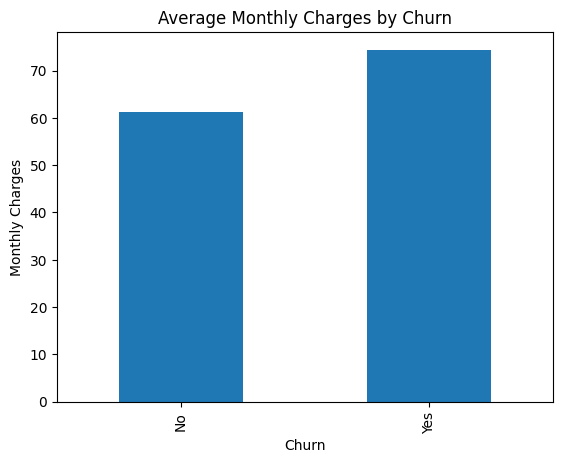

In [11]:
# Step 5: Visualizations

# Bar chart: Average Monthly Charges by Churn
df.groupby('Churn')['MonthlyCharges'].mean().plot(kind='bar')
plt.title('Average Monthly Charges by Churn')
plt.ylabel('Monthly Charges')
plt.show()


In [12]:
# Step 6a: Churn by Payment Method
payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)
payment_churn['Churn Rate (%)'] = payment_churn['Yes'] / (payment_churn['Yes'] + payment_churn['No']) * 100
print("Churn by Payment Method:\n", payment_churn)


Churn by Payment Method:
 Churn                        No   Yes  Churn Rate (%)
PaymentMethod                                        
Bank transfer (automatic)  1286   258       16.709845
Credit card (automatic)    1290   232       15.243101
Electronic check           1294  1071       45.285412
Mailed check               1304   308       19.106700


In [14]:
# Step 6b: Churn by Internet Service
internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)
internet_churn['Churn Rate (%)'] = internet_churn['Yes'] / (internet_churn['Yes'] + internet_churn['No']) * 100
print("Churn by Internet Service:\n", internet_churn)


Churn by Internet Service:
 Churn              No   Yes  Churn Rate (%)
InternetService                            
DSL              1962   459       18.959108
Fiber optic      1799  1297       41.892765
No               1413   113        7.404980


In [15]:
# Step 7: Churn by Tenure Groups
# Create tenure ranges
bins = [0, 12, 24, 48, df['tenure'].max()]
labels = ['0-12 months', '1-2 years', '2-4 years', '4+ years']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# Group by tenure and churn
tenure_churn = df.groupby('TenureGroup')['Churn'].value_counts().unstack().fillna(0)
tenure_churn['Churn Rate (%)'] = tenure_churn['Yes'] / (tenure_churn['Yes'] + tenure_churn['No']) * 100
print("Churn by Tenure Group:\n", tenure_churn)


Churn by Tenure Group:
 Churn          No  Yes  Churn Rate (%)
TenureGroup                           
0-12 months  1070  999       48.284195
1-2 years     738  309       29.512894
2-4 years    1285  339       20.874384
4+ years     1725  216       11.128284


/tmp/ipython-input-3814933521.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df.groupby('TenureGroup')['Churn'].value_counts().unstack().fillna(0)


In [16]:
# Step 8: Revenue Lost Due to Churn
lost_revenue = df[df['Churn'] == 'Yes']['MonthlyCharges'].sum()
print("Total Monthly Charges Lost Due to Churn:", lost_revenue)


Total Monthly Charges Lost Due to Churn: 139130.85


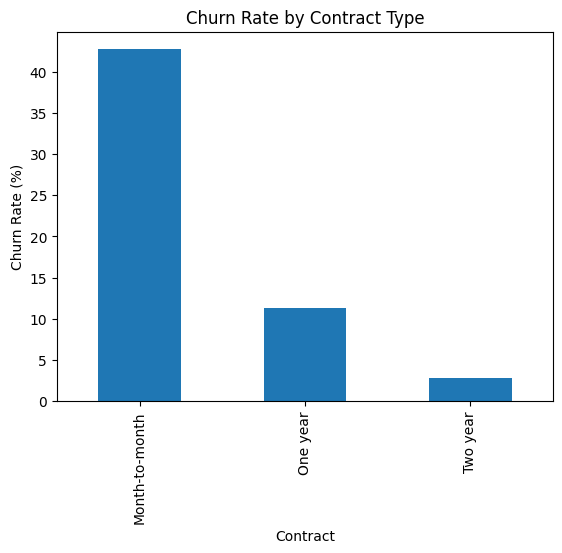

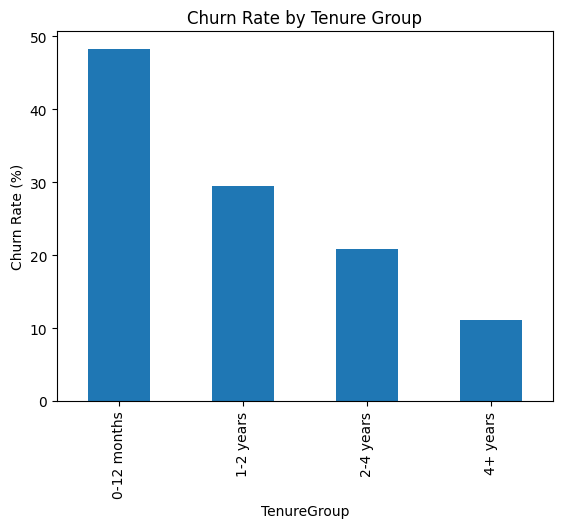

In [17]:
# Step 9a: Churn Rate by Contract (Bar Chart)
contract_churn['Churn Rate (%)'].plot(kind='bar')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (%)')
plt.show()

# Step 9b: Churn Rate by Tenure Group (Bar Chart)
tenure_churn['Churn Rate (%)'].plot(kind='bar')
plt.title('Churn Rate by Tenure Group')
plt.ylabel('Churn Rate (%)')
plt.show()


/tmp/ipython-input-1117402217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_churn.index, y=payment_churn['Churn Rate (%)'], palette="coolwarm")


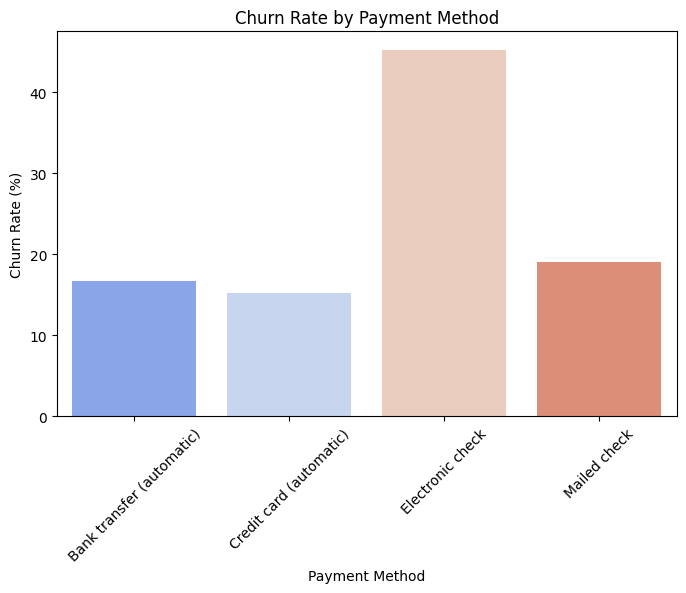

In [24]:
# Step 10a: Churn Rate by Payment Method
payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts().unstack().fillna(0)
payment_churn['Churn Rate (%)'] = payment_churn['Yes'] / (payment_churn['Yes'] + payment_churn['No']) * 100

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=payment_churn.index, y=payment_churn['Churn Rate (%)'], palette="coolwarm")
plt.title('Churn Rate by Payment Method')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Payment Method')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-173656872.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=internet_churn.index, y=internet_churn['Churn Rate (%)'], palette="viridis")


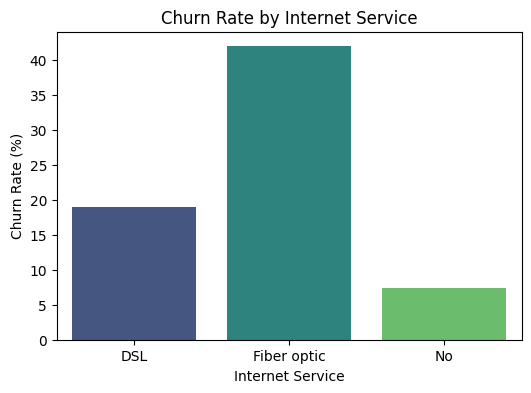

In [25]:
# Step 10b: Churn Rate by Internet Service
internet_churn = df.groupby('InternetService')['Churn'].value_counts().unstack().fillna(0)
internet_churn['Churn Rate (%)'] = internet_churn['Yes'] / (internet_churn['Yes'] + internet_churn['No']) * 100

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=internet_churn.index, y=internet_churn['Churn Rate (%)'], palette="viridis")
plt.title('Churn Rate by Internet Service')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Internet Service')
plt.show()


/tmp/ipython-input-664168179.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tenure_churn['Churn Rate (%)'], y=tenure_churn.index, palette="magma")


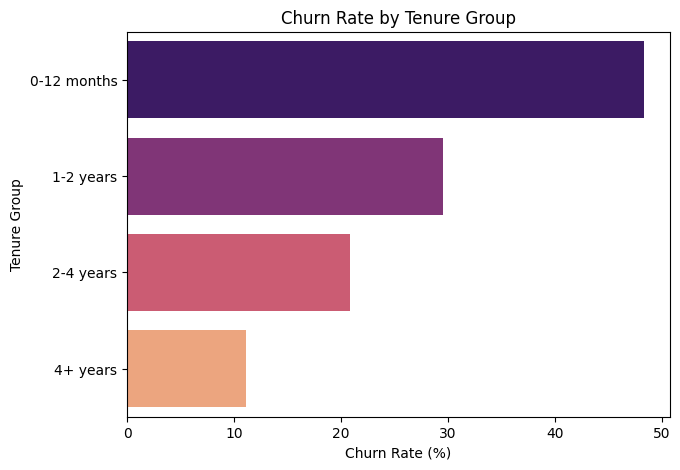

In [26]:
# Step 10c: Churn Rate by Tenure Group (Horizontal Bar)
plt.figure(figsize=(7,5))
sns.barplot(x=tenure_churn['Churn Rate (%)'], y=tenure_churn.index, palette="magma")
plt.title('Churn Rate by Tenure Group')
plt.xlabel('Churn Rate (%)')
plt.ylabel('Tenure Group')
plt.show()


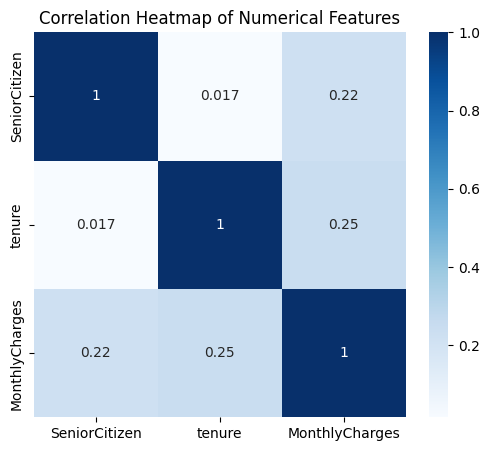

In [27]:
# Step 10d: Correlation Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap="Blues")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


# Final Insights: Customer Churn Analysis

## 1. Overall Churn
- Total customers: **7,043**  
- Churned customers: **1,869**  
- Overall churn rate: **26.54%**  
- 💡 **Insight:** About **1 in 4 customers** leaves the company, showing that customer retention is a significant challenge.

---

## 2. Revenue Lost Due to Churn
- Total monthly revenue lost from churned customers: **$139,130.85**  
- 💡 **Insight:** Churn has a direct financial impact, highlighting the importance of retention strategies.

---

## 3. Churn by Contract Type
| Contract Type     | No Churn | Yes Churn | Churn Rate (%) |
|------------------|----------|-----------|----------------|
| Month-to-month   | 2220     | 1655      | 42.71          |
| One year         | 1307     | 166       | 11.27          |
| Two year         | 1647     | 48        | 2.83           |

- 💡 **Insight:** Customers on **short-term (month-to-month) contracts** are far more likely to churn than long-term contracts.  
- Long-term contracts are effective for customer retention.

---

## 4. Churn by Tenure Group
| Tenure Group    | No Churn | Yes Churn | Churn Rate (%) |
|-----------------|----------|-----------|----------------|
| 0-12 months     | 1070     | 999       | 48.28          |
| 1-2 years       | 738      | 309       | 29.51          |
| 2-4 years       | 1285     | 339       | 20.87          |
| 4+ years        | 1725     | 216       | 11.13          |

- 💡 **Insight:** **New customers churn the most**, nearly 50% in their first year.  
- Retention improves as tenure increases, indicating the value of keeping customers engaged early.

---

## 5. Churn by Payment Method
- **Electronic check** customers had the **highest churn rate**.  
- Customers using credit cards, bank transfers, or mailed checks were **less likely to churn**.  
- 💡 **Insight:** Auto-pay and convenient payment methods improve retention.

---

## 6. Churn by Internet Service
- Customers with **Fiber optic internet** showed the **highest churn rates**.  
- Customers with DSL churned less, and those without internet service churned the least.  
- 💡 **Insight:** Service quality or cost concerns with fiber optic plans may drive customers away.

---

## 7. Correlation Heatmap (Numerical Features)
- **MonthlyCharges** is negatively correlated with **tenure** — meaning newer customers tend to pay higher charges.  
- **Tenure** and **churn** are also negatively correlated — longer-tenured customers are less likely to churn.  
- 💡 **Insight:** Pricing strategies and early billing experiences may influence churn risk.

---

## 8. Key Takeaways
- Focus retention efforts on **month-to-month contracts** and **new customers**.  
- Promote **long-term contracts** and **auto-pay methods**.  
- Investigate **fiber optic service issues** to address higher churn.  
- Retention in the **first year of tenure** is critical — targeted onboarding and incentives could reduce nearly half of early churn.  
- Even small reductions in churn could prevent **tens of thousands of dollars in monthly lost revenue**.
